## Example of Limit/Interval Estimation Using Hypothesis Test Inversion 

In [1]:
using namespace RooStats;
HypoTestInverter * calc = nullptr;
HypoTestInverterResult * result = nullptr; 
HypoTestInverterPlot * plot = nullptr; 
RooStats::TestStatistic * testStat = nullptr; 
RooStats::ToyMCSampler * toymcs = nullptr; 
RooStats::SamplingDistPlot * distplot = nullptr;
TCanvas * c1 = nullptr; 
TCanvas * c2 = nullptr; 

First part is just to access the workspace file and retrieve the model and the data 

In [2]:
TString fileName = "CountingModel.root";
TString workspaceName = "w";
TString modelConfigName = "ModelConfig";
TString dataName = "data";
TString integrationType = "";  
// Use Minuit2 for minimization
ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");

In [3]:
auto file = TFile::Open(fileName);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [4]:
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto sbModel = (RooStats::ModelConfig*) w->obj(modelConfigName);
auto  data = w->data(dataName);
auto poi = (RooRealVar*) sbModel->GetParametersOfInterest()->first();


RooWorkspace(w) w contents

variables
---------
(b,b0,nobs,s,sigmab)

p.d.f.s
-------
RooGaussian::constraint[ x=b0 mean=b sigma=sigmab ] = 1
RooProdPdf::model[ pdf * constraint ] = 0.195367
RooPoisson::pdf[ x=nobs mean=nexp ] = 0.195367

functions
--------
RooAddition::nexp[ s + b ] = 4

datasets
--------
RooDataSet::data(nobs)

parameter snapshots
-------------------
ModelConfig__snapshot = (s=3)

named sets
----------
ModelConfig_GlobalObservables:(b0)
ModelConfig_NuisParams:(b)
ModelConfig_Observables:(nobs)
ModelConfig_POI:(s)
ModelConfig__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



##### Make the b Model by cloning the b model and use a value = 0 for the parameter of interest

In [5]:
sbModel->GetSnapshot()->Print("V");

  1) RooRealVar:: s = 3


In [6]:
sbModel->SetName("S+B Model");
auto bModel = (RooStats::ModelConfig*) sbModel->Clone("B Model");
poi->setVal(0);
bModel->SetSnapshot( *poi  );
sbModel->GetSnapshot()->Print("V");

  1) RooRealVar:: s = 3


Create the Hypothesis test calculator. Note that in this case the NULL model is the S+B model. 

In [7]:
// RooStats::AsymptoticCalculator::SetPrintLevel(-1);  // to switch off print level 
RooStats::AsymptoticCalculator  asymCalc(*data, *bModel, *sbModel);

[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize....
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize - Find  best unconditional NLL on observed data
AsymptoticCalculator::EvaluateNLL  ........ using Minuit2 / Migrad with strategy  1 and tolerance 1
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 0.805423551781029756
Edm   = 6.14471779887919668e-07
Nfcn  = 42
b	  = 1.00005	 +/-  0.199847	(limited)
s	  = 2.00182	 +/-  1.71048	(limited)
AsymptoticCalculator::EvaluateNLL -  value = 0.805424	fit time : Real time 0:00:00, CP time 0.060
[#0] PROGRESS:Eval -- Best fitted POI value = 2.00182 +/- 1.71048
[#0] PROGRESS:Eval -- AsymptoticCalculator: Building Asimov data Set
[#1] INFO:InputArguments -- AsymptoticCalculator: Asimov data will be generated using fitted nuisance parameter values
MakeAsimov: Setting poi s to a constant value = 0
MakeAsimov: doing a conditional fit for finding best nuisan

Info in <Minuit2>: VariableMetricBuilder: no improvement in line search


In [8]:
asymCalc.SetOneSided(true);  // for one-side test (compute a limit)
//asymCalc.SetPrintLevel(-1);  // to suppress print level 

Create the HypoTestInverter calculator and configure it 

In [9]:
calc = new RooStats::HypoTestInverter(asymCalc); 

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : S+B Model
		 using as B (alternate) model  : B Model



Configure the calculator

In [10]:
calc->SetConfidenceLevel(0.95);
calc->UseCLs(true); 
calc->SetVerbose(false);

calc->SetFixedScan(10,0.0,20.0); // set number of points , xmin and xmax 

asymCalc.SetOneSided(true);  // for one-side test (compute a limit)
asymCalc.SetPrintLevel(-1); 

Run now the calculator to compute the interval 

In [11]:
result = calc->GetInterval();

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#0] WARNING:InputArguments -- HypoTestInverter::RunFixedScan - xMax > upper bound, use xmax = 15
[#1] INFO:InputArguments -- Minimum of POI is 0 corresponds to alt  snapshot   - using qtilde asymptotic formulae  
[#1] INFO:Eval -- Using one-sided qmu - setting qmu to zero  muHat = 2.00182 muTest = 0
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:Eval -- Using one-sided qmu - setting qmu to zero  muHat = 2.00182 muTest = 1.66667
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous s

In [12]:
cout << 100*calc->ConfidenceLevel() << "% interval is : ["<< result->LowerLimit() << ", "<< result->UpperLimit() <<"] "<<endl;

std::cout << "The computed upper limit is: " << result->UpperLimit() << std::endl;
  
  // compute expected limit
  std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
  std::cout << " expected limit (median) " << result->GetExpectedUpperLimit(0) << std::endl;
  std::cout << " expected limit (-1 sig) " << result->GetExpectedUpperLimit(-1) << std::endl;
  std::cout << " expected limit (+1 sig) " << result->GetExpectedUpperLimit(1) << std::endl;
  std::cout << " expected limit (-2 sig) " << result->GetExpectedUpperLimit(-2) << std::endl;
  std::cout << " expected limit (+2 sig) " << result->GetExpectedUpperLimit(2) << std::endl;

95% interval is : [0, 6.22563] 
The computed upper limit is: 6.22563
Expected upper limits, using the B (alternate) model : 
 expected limit (median) 3.60858
 expected limit (-1 sig) 2.62137
 expected limit (+1 sig) 5.92498
 expected limit (-2 sig) 1.64381
 expected limit (+2 sig) 9.2754


Plot now the result of the scan of the hypothesis tests

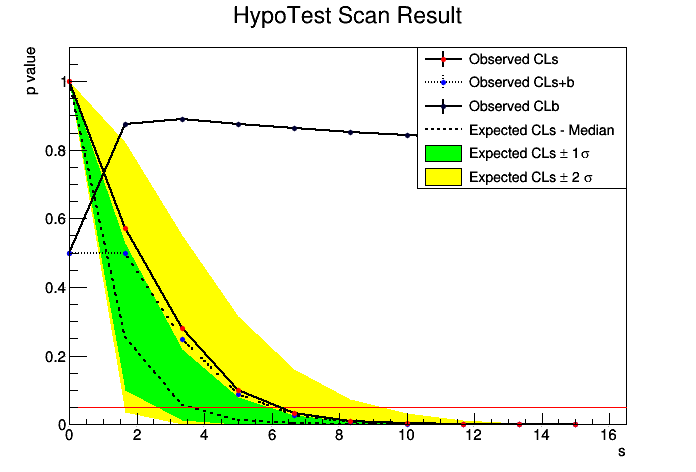

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [13]:
plot = new RooStats::HypoTestInverterPlot("HTI_Result_Plot","HypoTest Scan Result",result);
plot->Draw("CLb 2CL");  // plot also CLb and CLs+b 
gPad->Draw();

### Frequentist Calculator

We run now on the same model the FrequentistCalculator. The Frequentist Calculator uses the test statistic distributions obtained with pseudo-experiments.

In [14]:
RooStats::FrequentistCalculator   fc(*data, *bModel, *sbModel);

We configure the Frequentist calculator by specifying the number of toys for the two hypothesis 

In [15]:
fc.SetToys(1000,500);    // 1000 for null (S+B) and 500 for alt (B) 

We need also to specify the test statistics type. Here are some possible test statistics to use 

In [16]:
testStat = new RooStats::ProfileLikelihoodTestStat(*sbModel->GetPdf());
// needed for PL test statistics
if (dynamic_cast<RooStats::ProfileLikelihoodTestStat *>(testStat))
   ((RooStats::ProfileLikelihoodTestStat *)testStat)->SetOneSided(false);

In [17]:
toymcs = (RooStats::ToyMCSampler*)fc.GetTestStatSampler();
toymcs->SetTestStatistic(testStat);

In [18]:
// for number counting experiments (i.e. when we have only one event per toy)
// in general shape cases are extended model
if (!sbModel->GetPdf()->canBeExtended())
    toymcs->SetNEventsPerToy(1);

Run now the calculator. It can take some time... be patient 

In [34]:
calc = new RooStats::HypoTestInverter(fc);
calc->UseCLs(true);
calc->SetConfidenceLevel(0.95);  
calc->SetFixedScan(10,0.0,10.0); // set number of points , xmin and xmax 
// needed for PL test statistics
if (dynamic_cast<RooStats::ProfileLikelihoodTestStat *>(testStat))
   ((RooStats::ProfileLikelihoodTestStat *)testStat)->SetOneSided(true);
result = calc->GetInterval();

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : S+B Model
		 using as B (alternate) model  : B Model

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name S+B Model__snapshot

=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (nobs)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (b)
Global Observables:      RooArgSet:: = (b0)
PDF:                     RooProdPdf::model[ pdf * constraint ] = 0.349091
Snapshot:                
  1) 0x7fd431952c50 RooRealVar:: s = 0  L(0 - 15)  "s"


=== Using the following for B Model ===
Observables:             RooArgSet:: = (nobs)
Parameters of Interest:  RooArgSet:: = (s)
Nuisance Parameters:     RooArgSet:: = (b)
Global Observables:      RooArgSet:: = (b0)
PDF:                     RooProdPdf::model[ pdf * constraint ] = 0.34909

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Reached call limit


[#0] PROGRESS:Generation -- generated toys: 500 / 1000
    ----> Doing a re-scan first


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Reached call limit


    ----> Doing a re-scan first


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Reached call limit


[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.


In [30]:
cout << 100*calc->ConfidenceLevel() << "% interval is : ["<< result->LowerLimit() << ", "<< result->UpperLimit() <<"] "<<endl;

std::cout << "The computed upper limit is: " << result->UpperLimit() << std::endl;
  
  // compute expected limit
  std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
  std::cout << " expected limit (median) " << result->GetExpectedUpperLimit(0) << std::endl;
  std::cout << " expected limit (-1 sig) " << result->GetExpectedUpperLimit(-1) << std::endl;
  std::cout << " expected limit (+1 sig) " << result->GetExpectedUpperLimit(1) << std::endl;
  std::cout << " expected limit (-2 sig) " << result->GetExpectedUpperLimit(-2) << std::endl;
  std::cout << " expected limit (+2 sig) " << result->GetExpectedUpperLimit(2) << std::endl;

95% interval is : [1.22257e-16, 7.21923] 
The computed upper limit is: 7.21923
Expected upper limits, using the B (alternate) model : 
 expected limit (median) 4.34312
 expected limit (-1 sig) 3.9335
 expected limit (+1 sig) 5.4776
 expected limit (-2 sig) 3.69355
 expected limit (+2 sig) 8.0223


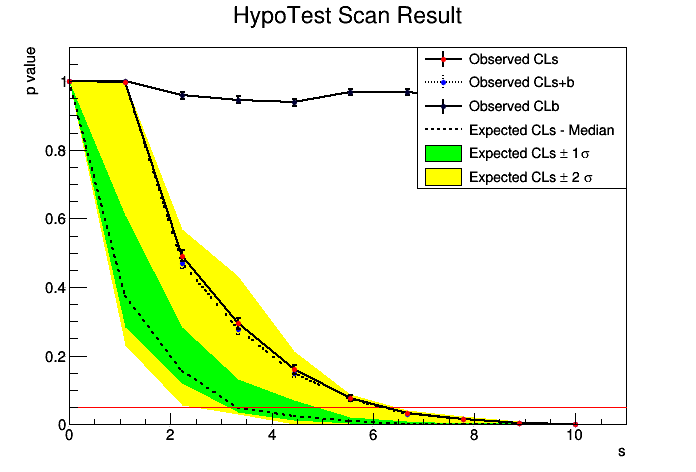

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [35]:
c1 = new TCanvas("c1","HypoTest Scan Result");
plot = new RooStats::HypoTestInverterPlot("HTI_Result_Plot","HypoTest Scan Result",result);
plot->Draw("CLb 2CL");  // plot also CLb and CLs+b 
c1->SetLogy(0);
c1->Draw();

Plot now the test statistics distributions for some of the scanned points

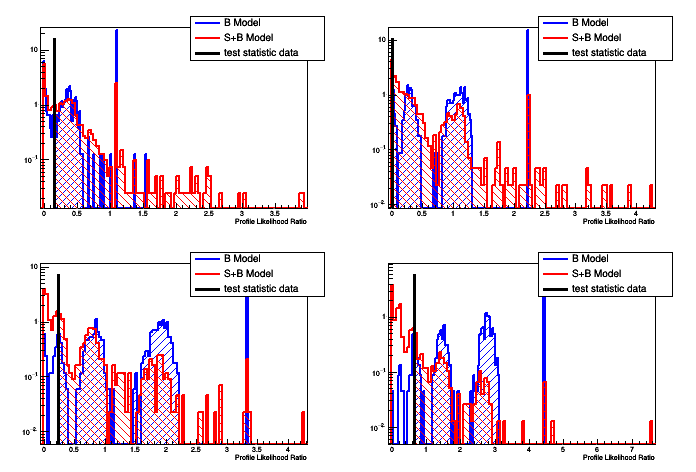

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


In [28]:
c2 = new TCanvas("c2","Test Statistic Distributions");
c2->Divide(2,2);
for (int i = 1; i < 5 && i < result->ArraySize(); ++i){
    c2->cd(i);
    distplot = plot->MakeTestStatPlot(i);
    distplot->SetLogYaxis(true);
    distplot->Draw();
}
c2->Draw()

Info in <TCanvas::Print>: ps file c2.ps has been created


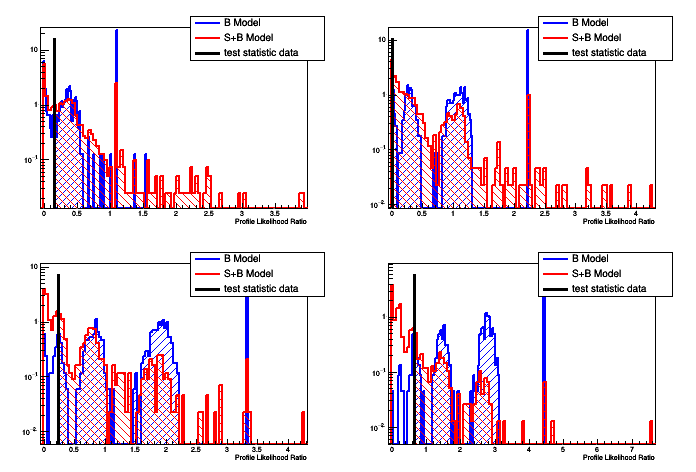